In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
  
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Loading Data...**

In [71]:
# Importing Libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from skimage import color
from skimage import io
import tensorflow as tf
import scipy.io as sio
from tensorflow.keras import models, layers
import os
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten  # Importing CNN Module
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

In [72]:
# Loading dataset..

def load_data(path):
    data = loadmat(path)
    return data['X'], data['y']

X_train, y_train = load_data("/kaggle/input/svhndataset/train_32x32.mat")
X_test, y_test = load_data("/kaggle/input/svhndataset/test_32x32.mat")

print("Training set", X_train.shape, y_train.shape)

Training set (32, 32, 3, 73257) (73257, 1)


In [73]:
# Creating Transpose Matrix
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]

print("Training Set", X_train.shape)
print('')

print("Test Set", X_test.shape)
print('')

Training Set (73257, 32, 32, 3)

Test Set (26032, 32, 32, 3)



In [54]:
X_train[0].shape

(32, 32, 3)

# Step-1: Preprocessing 

In [74]:
#Normalization/Rescaling
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [75]:
# One-hot encode the labels
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [76]:
# Spliting the training data into 80% training and 20% validation
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Step-2: Data augmentation  on SVHN using Tensorflow

In [77]:
# Converting Training Data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_split, y_train_split))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_split, y_test_split))

# Defining augmentation for training dataset
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    return image, label

# Creating the augmented training dataset
augmented_train_dataset = train_dataset.map(augment_image)
augmented_train_dataset = augmented_train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Creating the test dataset
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Checking shapes
for images, labels in augmented_train_dataset.take(1):
    print(f"Augmented Train Batch shape: {images.shape}, Labels shape: {labels.shape}")

for images, labels in test_dataset.take(1):
    print(f"Test Batch shape: {images.shape}, Labels shape: {labels.shape}")


Augmented Train Batch shape: (32, 32, 32, 3), Labels shape: (32, 10)
Test Batch shape: (32, 32, 32, 3), Labels shape: (32, 10)


# Step-3: Dataset Training

In [78]:
# Building model
model = models.Sequential([
    layers.InputLayer(input_shape=(32, 32, 3)),  # Update input shape to (32, 32, 3)

    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),  # Output shape will be (16, 16, 32)

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),  # Output shape will be (8, 8, 64)

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),  # Output shape will be (4, 4, 128)

    # Flatten and Dense layers
    layers.Flatten(),  # Flattening will yield 4 * 4 * 128 = 2048 inputs
    layers.Dense(128, activation='relu'),  # 128 neurons in this layer
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
])


**Model Summary**

In [80]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,202 (625.79 KB)

 Trainable params: 160,202 (625.79 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
# model compilation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [82]:
history = model.fit(augmented_train_dataset, validation_data=test_dataset, epochs=20)


Epoch 1/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 60s 31ms/step - accuracy: 0.4655 - loss: 1.5412 - val_accuracy: 0.7862 - val_loss: 0.6885
Epoch 2/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 57s 31ms/step - accuracy: 0.8033 - loss: 0.6475 - val_accuracy: 0.8449 - val_loss: 0.5153
Epoch 3/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 57s 31ms/step - accuracy: 0.8404 - loss: 0.5190 - val_accuracy: 0.8539 - val_loss: 0.4798
Epoch 4/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 56s 31ms/step - accuracy: 0.8602 - loss: 0.4541 - val_accuracy: 0.8668 - val_loss: 0.4421
Epoch 5/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 56s 31ms/step - accuracy: 0.8721 - loss: 0.4143 - val_accuracy: 0.8586 - val_loss: 0.4693
Epoch 6/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 57s 31ms/step - accuracy: 0.8819 - loss: 0.3860 - val_accuracy: 0.8746 - val_loss: 0.4154
Epoch 7/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 57s 31ms/step - accuracy: 0.8901 - loss: 0.3647 - val_accuracy: 0.8726 - val_loss: 0.4324
Epoch 8/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 56s 31ms/step - accuracy: 0.8961 -

In [83]:
# validation and training curves
def plot_loss_curves(history):
  """
  Returns seperate Loss curves for training and validation metrics
  """
  loss= history.history["loss"]
  val_loss= history.history["val_loss"]

  accuracy= history.history["accuracy"]
  val_accuracy= history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # PLot Loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # PLot accuracy
  plt.figure() # Create a new figure
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

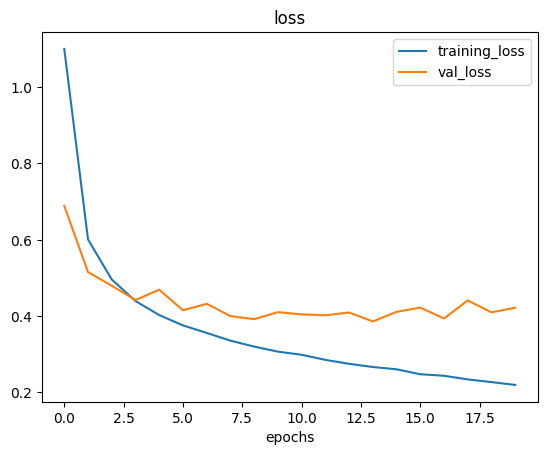

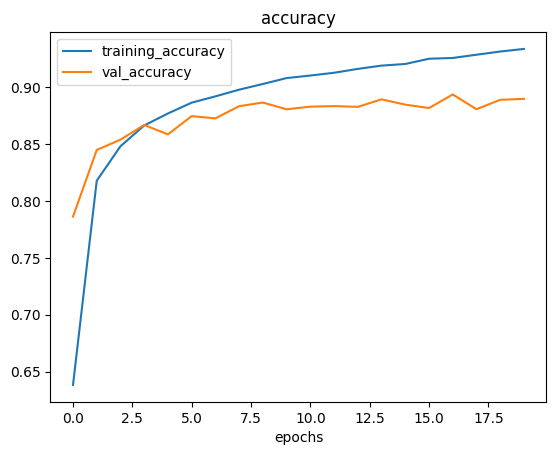

In [84]:
plot_loss_curves(history)

# Step-4: Model testing

In [85]:
# Creating the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Evaluating the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")


814/814 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8839 - loss: 0.4595
Test accuracy: 0.8862937688827515
Test Loss: 0.44916558265686035


# Step-6: Confusion Matrix

814/814 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


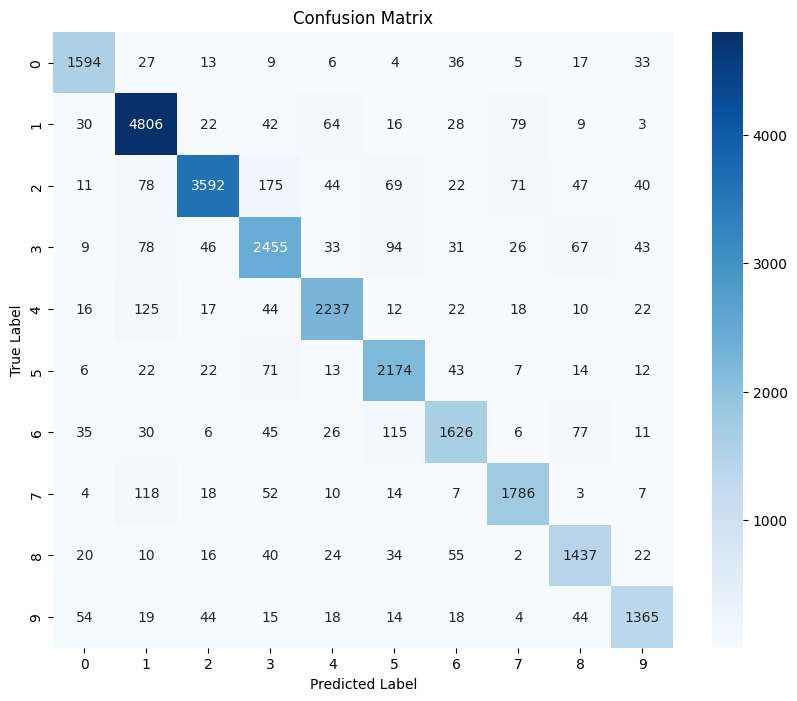

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Making predictions on the test dataset
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels back to class labels

# 2. Creating confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# 3. Ploting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()